# Project 3 - Disease Detection_COVID19 [NOTEBOOK 2]

## Introduction:

In Notebook (1), an initial build of the ResNet-50 was built to classify patients that presents with the following classes: COVID-19, Normal, Viral-pneumonia or Bacterial-pneumonia. It was found that the initial model had some issues that missclassify some of these labels.


Highlighted Issues:
-  It was able to correctly identify COVID-19 and Bacterial Pneumonia well, but struggles with the Normal and Viral Pneumonia classes, where it miss classifies these often.
- Overall accuracy was only ~75% on test data while ~85% on validation data.

## The methods that will be tested to improve on its classification results are:
1. Increasing the Validation set ( trying out 70/30 split rather than 80/20)
2. Decrease the Learning rate.
3. Address the Imbalance image datasets with Weighted Loss.
4. The ResNet model requires some regularisation (perhaps in the Fully-Connected Layers)4. The ResNet model's Fully-Connected layers may need to be altered to have deeper layers or less nodes.

### Note: 

Unlike in Notebook 1, where the it details the step-by-step code blocks, in this notebook, the majority of the code will be moved to the following ".py" utility files and be called into this notebook. This is simpify this notebook.
- Plotting_Utilities.py
- ResNet_model.py (the model itself was modified for this notebook)
- Custom_KerasCallbacks_Utility.py


## Breakdown of this Project:
1. Loading in the Dataset.
2. Exploratory Data Analysis (Visualise the data).
3. Examining the Outliers.
4. Dataset preparation (Data cleaning, training and testing splits)
5. Building the CNN Model  (ResNet)
6. Training the Model.
7. Evaluating the Model.
8. Prediction implementation.
9. Model Improvements.


## Dataset:

Link: https://www.kaggle.com/unaissait/curated-chest-xray-image-dataset-for-covid19

As quoted from the link, the description is:

This is a combined curated dataset of COVID-19 Chest X-ray images obtained by collating 15 publically available datasets as listed under the references section. The present dataset 
contains:
- 1281 COVID-19 X-Rays.
- 3270 Normal X-Rays.
- 1656 viral-pneumonia X-Rays.
- 3001 bacterial-pneumonia X-Rays.

## Requirements:
- Numpy
- Pandas
- Seaborn
- Matplotlib
- scikit-learn (sklearn)
- os
- timeit
- OpenCV2  (cv2)
- glob
- tensorflow (or Keras)

## 1 - Setting up the Libraries:

In [1]:
# Import the required Library:
import os
import cv2
import glob
import timeit
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 


## 2 - Load in the Dataset:

#### Define the Global Dataset Parameters:

In [2]:
# Define the Hyperparameters:
input_shape = [224, 224, 3]
batch_size = 64
nb_epochs = 300

#### Set up the Directory to the Dataset:

In [3]:
# Dataset Filename:
dataset_fileName = 'Curated X-Ray Dataset'

# Set up the Working Directory:
currentDirectory = os.getcwd()
path_to_dataset = currentDirectory + '/Dataset/' + dataset_fileName

In [4]:
# List out the Sub-Folders in the Dataset folder: These are the Classes of images.
os.listdir(path_to_dataset)

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

#### Things to consider before loading in the dataset:
1. Define the batch size, is the number of images in each batch to train on.
2. Shuffling the image data randomly.
3. Resize the image resolution/data, e.g. (224 x 224 x 3) according to ResNet-50 authors)

Luckily, Tensorflow.Keras API has a very useful module called "ImageDataGenerator" that is able to simplify these steps without explicitly define specfic python functions to perform thhe following:
- extracting and loading the images.
- a defined parsing function.
- a defined augmentation function.
- a shuffling function.
- scaling the images.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [5]:
# Import the required library:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
# Instantiate the Module: ImageDataGenerator. Method 1 -> Increasing the Validation set to 30%
imgGen = ImageDataGenerator(rescale=1. / 255, 
                            validation_split=0.3)

#### For the Training Set of images:

In [7]:
train_generator = imgGen.flow_from_directory(directory=path_to_dataset,
                                             target_size=tuple(input_shape[:-1]), 
                                             class_mode='categorical', 
                                             batch_size=batch_size,
                                             shuffle=True,
                                             subset='training')

Found 6447 images belonging to 4 classes.


#### For the Validation Set of images:

In [8]:
validation_generator = imgGen.flow_from_directory(directory=path_to_dataset,
                                                  target_size=tuple(input_shape[:-1]), 
                                                  class_mode='categorical', 
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  subset='validation')

Found 2761 images belonging to 4 classes.


### 2.1 - Set the "steps_per_epoch" for Training and Validation Set:

This is the number of batches per epoch of the Dataset objects that has to be specified for the Keras method so that it can work properly together. This is done for the training batches ("steps_per_epoch") and validation batches ("validation_steps").

In [9]:
# Import the required library:
import math

In [10]:
train_steps_per_epoch = math.ceil(train_generator.samples / batch_size)

valid_steps_per_epoch = math.ceil(validation_generator.samples / batch_size)

### 2.2 - Inspect the Training and Validation Sets:

Create a sample of training set images and labels to inspect.

In [11]:
train_imgs, train_labels = next(train_generator)

In [12]:
train_imgs.shape, train_labels.shape

((64, 224, 224, 3), (64, 4))

So here, the training images in each batch consists of 64 images, with a resolution of (224 x 224) and have 3 colour channels (RGB). Interestingly, the labels have 64 label samples but has 4 column/values in it.

Let's have a look at the labels to see why, taking 5 sample of the labels:

In [13]:
train_labels[0:5]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

So these should correspond to the 4 labels of this dataset: \
['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

Next, is to translate these so that it is understandable later on during the training and prediction stages of this project.

In [14]:
# Define a label dictionary:
label_names_mapping = {0: os.listdir(path_to_dataset)[0], 
                       1: os.listdir(path_to_dataset)[1], 
                       2: os.listdir(path_to_dataset)[2], 
                       3: os.listdir(path_to_dataset)[3]}

# Inspect:
label_names_mapping

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}

Great, now that the dataset is set up, on to the next section.

## 3 - Exploratory Data Analysis (EDA):

Here in this section, some visualisations will be performed on the dataset to get a feel of the data.

### 3.1 - Dataset Sample Counts:

Let's have a look at the number of samples in each of the classes/labels.


In [15]:
# Count all of the images for each class:
count_class_0 = 0
count_class_1 = 0
count_class_2 = 0
count_class_3 = 0

dataset_train_val = [train_generator, validation_generator]

for data_type_set in dataset_train_val:
    for i in data_type_set.labels:
        if i == 0:
            count_class_0 += 1
        elif i == 1:
            count_class_1 += 1
        elif i == 2:
            count_class_2 += 1
        else:
            count_class_3 += 1

In [16]:
# Define the Counts and Labels Numpy Arrays:
counts_images = np.array(object=[count_class_0, count_class_1, 
                                 count_class_2, count_class_3])

label_images =  np.array(object=['COVID-19', 'Normal', 
                                 'Pneumonia-Bacterial', 'Pneumonia-Viral'])

# Create a DataFrame to hold the values:
image_df_plotting = pd.DataFrame({'counts':counts_images, 'labels':label_images})

# Inspect the DataFrame:
image_df_plotting

,counts,labels
0,1281,COVID-19
1,3270,Normal
2,3001,Pneumonia-Bacterial
3,1656,Pneumonia-Viral


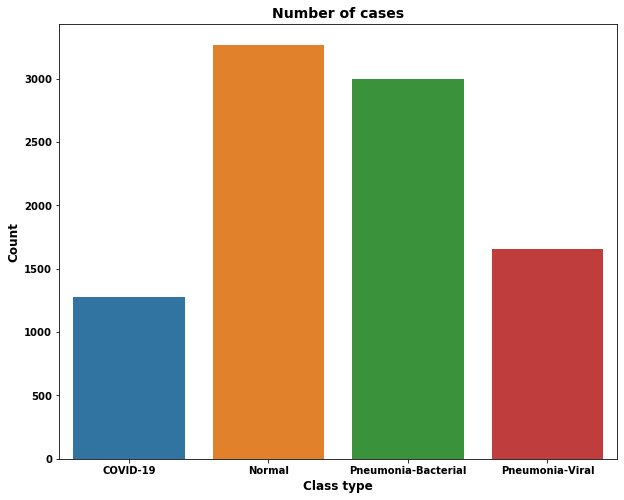

In [17]:
# Plot:
plt.figure(figsize=(10,8))
sns.barplot(x=image_df_plotting.labels, y=image_df_plotting.counts, palette='tab10')
plt.title('Number of cases', fontsize=14)
plt.xlabel('Class type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


### 3.2 - Visualise the Dataset according to each class:

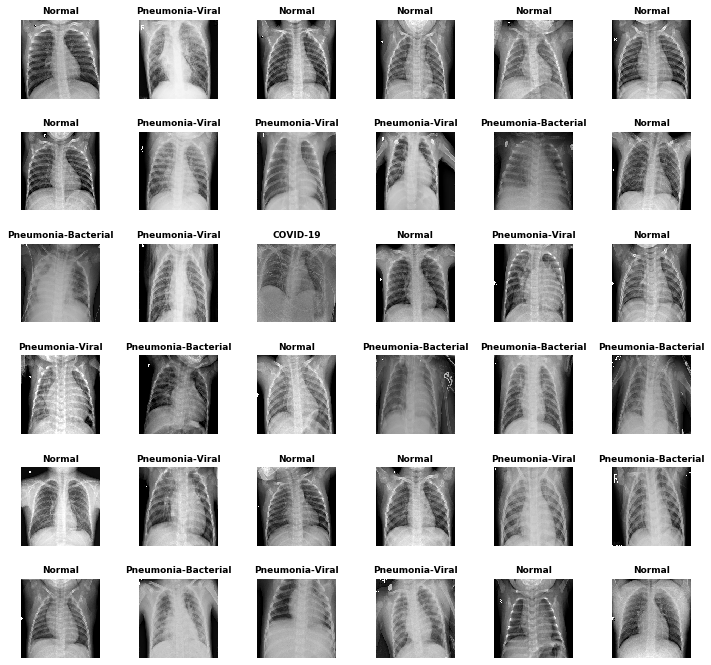

In [18]:
# Define the Grid Size:
grid_size = [6, 6]
grid_area = grid_size[0] * grid_size[1]

# Create a visualisation grid to plot:
fig, ax = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
ax = ax.ravel()

for i in np.arange(0, grid_area):
    ax[i].imshow(train_imgs[i])
    ax[i].set_title(label_names_mapping[ np.argmax(train_labels[i]) ], fontsize=9)
    ax[i].axis('off')
    
    
plt.subplots_adjust(wspace=0.5)


## 4 - Build the ResNet Model:

The building blocks of the ResNet model was moved to "ResNet_model.py" file and in this notebook, the model will be instantiate by calling it directly. The step by step code blocks will be remove in favour of simplifying thhis notebook.

### 4.1 - Import the ResNet Implementation with Keras API from the ".py" file:

In [19]:
# Import the required Libraries:
from ResNet_model import ResNet50
from tensorflow.keras import regularizers

## 5 - Train the ResNet Model for this Task:

Here the Current Model utilised will be: __ResNet-50__ model  (Modifiied)

The architecture in the fully-connected layer will be altered from having just one hidden layer of 1,024 nodes + dropout to several more layers:
- 2 hidden layers: 1st hidden layer (nodes=256) + dropout and 2nd hidden layer (nodes=128) + dropout.

#### Instantiate the model: with two hidden layers.

In [20]:
# Define the number of Classes:
nb_classes = len(np.unique(train_generator.labels))

# Instantiate the model:
resnet50_tune3 = ResNet50(input_shape=input_shape,
                         nb_classes=nb_classes,
                         use_bias=True,
                         use_dropout=True,
                         kernel_initialiser='he_normal',
                         kernel_regulariser=None)

# Model Summary:
resnet50_tune3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_bn_Relu_c (Conv2D)         (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv_bn_Relu_bn (BatchNormaliza (None, 112, 112, 64) 256         conv_bn_Relu_c[0][0]             
__________________________________________________________________________________________________
conv_bn_Relu_r (Activation)     (None, 112, 112, 64) 0           conv_bn_Relu_bn[0][0]            
______________________________________________________________________________________________

### 5.1 - Preparation for Training:

Instantiate the model optimiser and the required callbacks for visualisation of the model performance. This also saves the model's progress and results.

In [21]:
# Import the Required Libraries:
import collections
from Custom_KerasCallbacks_utility import Simplified_LogCallback

#### Callbacks:

This section will implement a custom Callback Class. It defines an interface that is composed of several methods, that will be called by Keras during the training process. The intervals for calling Keras are "before each epoch", "before each batch iteration", "after each batch iteration" and so on.

NOTE: to ensure that the logs are concise, a "log_frequency" variable will be used to print out the results at different intervals during the training process.


In [22]:
# Set up Path Directory to Save the Model:
model_name = 'ResNet50_Covid19_tuning3'
model_dir = os.path.join('.', 'models', model_name)

# Set up the Metrics to Print:
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc")] 
                                          )

callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor='loss',
                                     patience=8,
                                     restore_best_weights=True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period=5),
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print, 
                                             nb_epochs = nb_epochs, 
                                             log_frequency= 2)

    ]


#### Load Saved Weights:

Create a folder called "models" in directory.

In [23]:
# Check if "models" folder has been created or not: create it if not found.
models_directory = os.path.join(currentDirectory, r'models')
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Load Previous Model Weights (when kernel crashes):
found_folder = None
for weight_folder in os.listdir('.\\models\\'):
    if(model_dir.split('.\\models\\')[1] == weight_folder):
        found_folder = str(weight_folder)
        
if(model_dir.split('.\\models\\')[1] == found_folder):
    # Set the model to load for:
    model = resnet50_tune3 # <========================== Set History Object here.

    All_saved_weightFiles = []
    for filename in os.listdir(model_dir):
        if 'weights-epoch' in filename:
            All_saved_weightFiles.append(filename)
            weights_file_name = All_saved_weightFiles[-1]
            model.load_weights(model_dir + '/' + weights_file_name)
    
    if not All_saved_weightFiles:
        print('Folder found, but Weights file was not found, Proceeding to creating a new one.')
        pass
    else:
        print("Model's weigth folder was found, proceeding to using previous Saved Weights.")
        print("Saved Weights Filename -> {}".format(weights_file_name))
        
else:
    print("Model's weight folder was not found inside '.\models\' folder. Proceeding to creating a new one.'")
    pass 

Model's weight folder was not found inside '.\models' folder. Proceeding to creating a new one.'


### 5.2 - Training the Model: ResNet-50

#### Compile the model:

Here, the decrease the learning rate was employed to improve on the erratic training behaviour (validation loss and accuracy). Therefore "learning_rate=0.0001" was set.

In [24]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Define the accuracy metric:
accuracy_metric = tf.metrics.CategoricalAccuracy(name='acc')


In [25]:
resnet50_tune3.compile(optimizer = optimiser,
                      loss = 'categorical_crossentropy',
                      metrics = [accuracy_metric]
                     )

### Weighted Loss for the Imbalance Dataset:

In [26]:
# Import the required library:
from collections import Counter

In [27]:
# Count the number of images that belong to each class:
counter = Counter(train_generator.classes)   

# Define the Maximum value:
max_val = float(max(counter.values()))  

# Compute the weights according to each class:
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

print(class_weights)

{0: 2.551839464882943, 1: 1.0, 2: 1.0894811994288434, 3: 1.9732758620689654}


#### Train the Model:

In [28]:
# running time calculation
start = timeit.default_timer()

history_resnet50_model_tune3 = resnet50_tune3.fit(train_generator,
                                                  epochs=nb_epochs,
                                                  steps_per_epoch=train_steps_per_epoch,
                                                  validation_data=validation_generator,
                                                  validation_steps=valid_steps_per_epoch,
                                                  verbose=0,
                                                  callbacks=callbacks,
                                                  class_weight=class_weights) # <= Imbalance  class fix.

# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training: start
Epoch  1/300: loss = 0.823; v-loss = 2.824; acc = 0.747; v-acc = 0.267
Epoch  3/300: loss = 0.573; v-loss = 1.361; acc = 0.819; v-acc = 0.505
Epoch  5/300: loss = 0.399; v-loss = 0.745; acc = 0.886; v-acc = 0.810
Epoch  7/300: loss = 0.280; v-loss = 1.605; acc = 0.926; v-acc = 0.769
Epoch  9/300: loss = 0.156; v-loss = 4.478; acc = 0.960; v-acc = 0.551
Epoch 11/300: loss = 0.124; v-loss = 1.530; acc = 0.971; v-acc = 0.798
Epoch 13/300: loss = 0.093; v-loss = 3.286; acc = 0.976; v-acc = 0.771
Epoch 15/300: loss = 0.086; v-loss = 3.387; acc = 0.980; v-acc = 0.631
Epoch 17/300: loss = 0.045; v-loss = 1.515; acc = 0.989; v-acc = 0.779
Epoch 19/300: loss = 0.070; v-loss = 2.494; acc = 0.983; v-acc = 0.702
Epoch 21/300: loss = 0.038; v-loss = 1.156; acc = 0.991; v-acc = 0.824
Epoch 23/300: loss = 0.057; v-loss = 2.072; acc = 0.988; v-acc = 0.750
Epoch 25/300: loss = 0.018; v-loss = 1.751; acc = 0.996; v-acc = 0.842
Epoch 27/30

### Observation:


## 6 - Plot the Model's Performance during Training Phase:

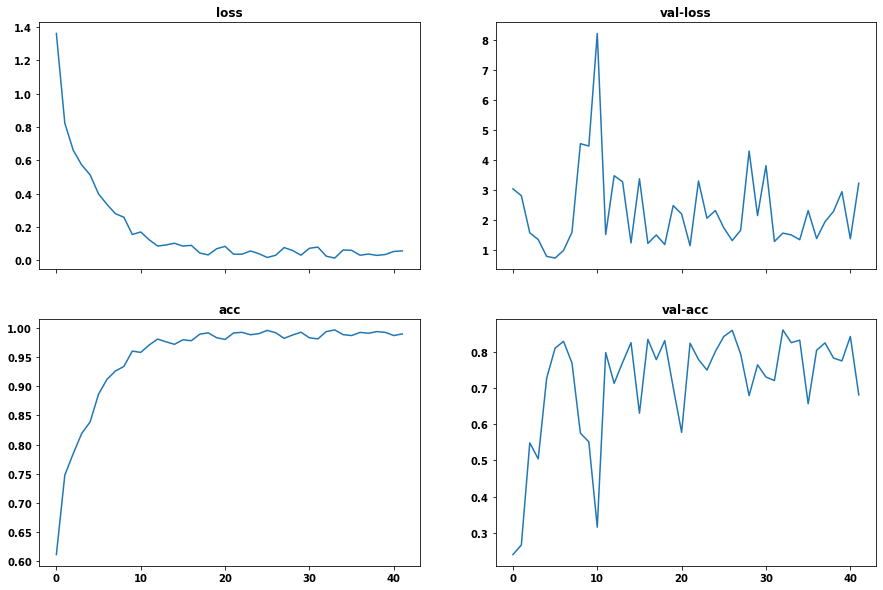

In [29]:
# Define the History Object to plot with:
history = history_resnet50_model_tune3

# Plot:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])



In [30]:
# Get the best performing scores:
best_val_accuracy = max(history.history['val_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))


Best Validation Accuracy: 86.06%


#### Save the Model:

In [31]:
resnet50_tune3.save(filepath= 'saved_model/' + 'resnet50_model_tune2.hdf5', 
                                 overwrite=True, 
                                 include_optimizer=True)

### Observation:

The validation accurcy achieved here was slightly less than the previous model (86.91%). Thhe validation loss and accuracy still presents with thhe erratic behaviour despite the improvement methods applied. This could mean that the validation images, that was used to compute the model's loss and update the weights, has more variaty in them and could have  confused the model during training. Nonetheless, the validation accuracy was still able to achieve ~86%, which could mean that some accuracy was sacrificed for precision.


## 7 - Testing the Model: Model Predictions with Unseen Data.

In [32]:
# Import the required libraries:
from Plotting_Utilities import (load_image, process_predictions, display_predicitons, eval_model)

### 7.1 - Predict and Plot the Results:

These images are taken from the web randomly.

#### 7.1.1 - Load in the Testing Images:

In [94]:
# Define the path to the testing 
test_directory = currentDirectory + '\\Testing Images from Web'

# Load in the images:
original_labels = []
testing_imgs = []

for i in os.listdir(test_directory):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = load_image(image_path=os.path.join(test_directory, str(i), item), size=input_shape[:2])
        testing_imgs.append(img)
        original_labels.append(i)

# Convert to Numpy Array:
testing_imgs = np.asarray(testing_imgs)

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 224, 224, 3)


### 7.1.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions. To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

In [95]:
# Define the batch of images:
img_batch = testing_imgs[:]

# Perform the testing image resize:
testing_original_imgSize = testing_imgs.shape[1:-1]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = testing_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = input_shape[:2])

# # Predictions:
predictions = resnet50_tune3.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))


predicted class probabilities: (16, 4)


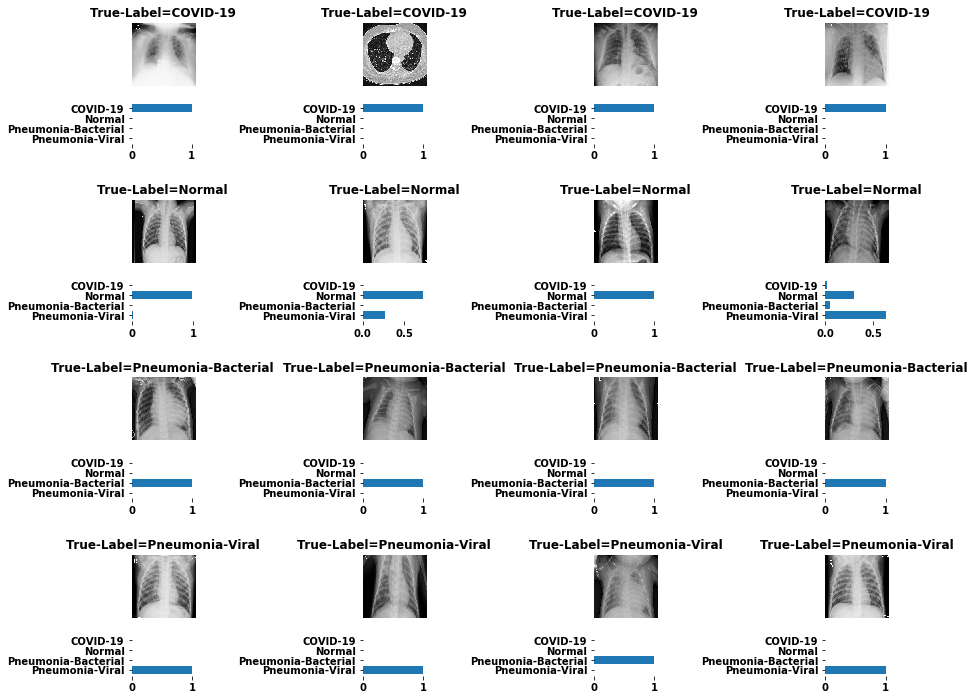

In [96]:
# Plot: using the utility funcs.
class_readable_labels = list(label_images)
top4_labels, top4_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images= img_batch, 
                    topk_labels= top4_labels, 
                    topk_probabilities= top4_probs, 
                    true_labels=original_labels, 
                    set_true_labels=True)

### Observation:

Upon manual inspection, 

### 7.1.3 - Evaluation:

In [97]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 4,
                                              directory= test_directory, 
                                              shuffle= True, 
                                              target_size=input_shape[:2], 
                                              class_mode= 'categorical')

evaluate = resnet50_tune3.evaluate_generator(test_generator, 
                                            steps=test_generator.n // 4, 
                                            verbose=1)

print('Accuracy Test : {}%'.format(evaluate[1] * 100))

Found 16 images belonging to 4 classes.
  ...
    to  
  ['...']
4/4 [==============================] - 0s 54ms/step - loss: 0.8503 - acc: 0.8750
Accuracy Test : 87.5%


                     precision    recall  f1-score   support

           COVID-19       1.00      1.00      1.00         4
             Normal       1.00      0.75      0.86         4
Pneumonia-Bacterial       0.80      1.00      0.89         4
    Pneumonia-Viral       0.75      0.75      0.75         4

           accuracy                           0.88        16
          macro avg       0.89      0.88      0.87        16
       weighted avg       0.89      0.88      0.87        16

 
Test Accuracy : 87.5%
 


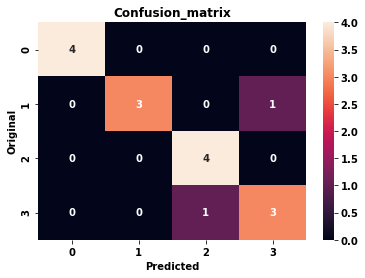

In [98]:
accuracy_score, model_confusion_matrix, model_classification_report = eval_model(label_names_mapping,
                                                                                 original_labels,
                                                                                 predictions)

In [99]:
label_names_mapping

{0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia-Bacterial', 3: 'Pneumonia-Viral'}

### Observation:

#####  Below shows the evaluation results from the original trained model without tuning methods:
<img src="Description Images/ResNet_untuned.PNG" width="350">

Image Ref -> self-made

Notice that the Testing Accuracy improve from 75% (previously) to 87.5%. It is also greater than thhe validation accuracy. This is great as it means the model should be able to classify the images more accurate. 

Taking a look at the confusion matrix vs the previous one, it does indeed indicate a better result, where it was able to classify Normal and Viral Penumonia patients better. The employed improvements to the model succeeded in making it more robust and accurate, where it can be argued that it can be ready for deployment in practice.